In [2]:
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn import *
from torch import nn
import torch.utils.data as data 

import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('dark_background')

import pandas as pd

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [3]:
x = np.arange(0, 1000000, 45)/100 #+ np.random.normal(size=(np.arange(0, 10000, 23)/100).shape) * 0.1
sin = np.sin(x) #+ np.random.normal(size=x.shape) * 0.1

In [4]:
df = pd.DataFrame(sin, columns=["sin"])
df["x"] = x

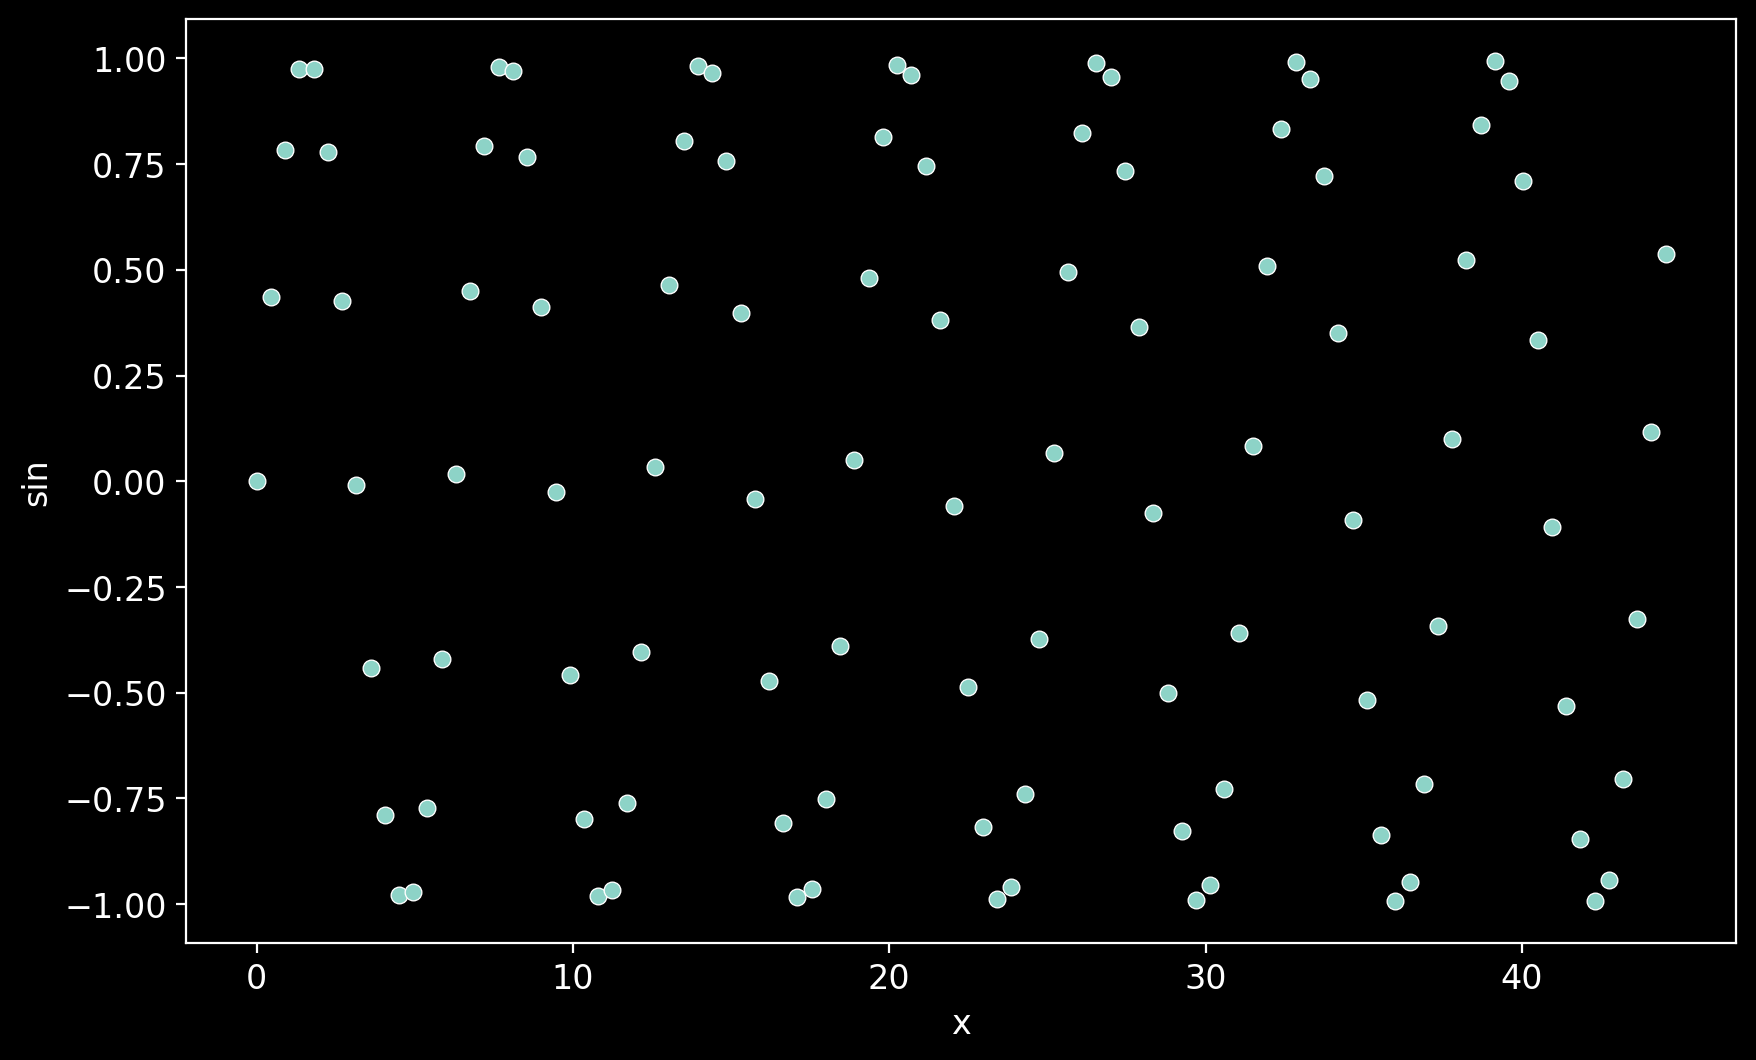

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df.iloc[:100], x="x", y="sin", ax=ax);

In [6]:
class TimeSeriesDataset(data.Dataset):
    def __init__(self, data, seq_len, forecast_len):
        self.data = data
        self.seq_len = seq_len
        self.forecast_len = forecast_len
    
    def __len__(self):
        return len(self.data) - self.seq_len - self.forecast_len
    
    def __getitem__(self, idx):
        return self.data[idx:idx+self.seq_len], self.data[idx+self.seq_len:idx+self.seq_len+self.forecast_len]

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X = torch.Tensor(df["sin"].values).unsqueeze(-1).to(device)
X_norm = (X - X.mean()) / X.std()

batch_size = 64

X_train = X_norm[:int(0.8*len(X_norm))]
X_val = X_norm[int(0.8*len(X_norm)):]

train_ds = TimeSeriesDataset(X_train, 15, 15)
val_ds = TimeSeriesDataset(X_val, 15, 15)

trainloader = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valloader = data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [8]:
##########################
# Autor: Junyeob Baek
# email: wnsdlqjtm@gmail.com
##########################

import torch
from torch import nn
from torch.nn import functional as F


class Encoder(nn.Module):
    def __init__(self, input_size=4096, hidden_size=1024, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )

    def forward(self, x):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        outputs, (hidden, cell) = self.lstm(x)
        return (hidden, cell)


class Decoder(nn.Module):
    def __init__(
        self, input_size=4096, hidden_size=1024, output_size=4096, num_layers=2
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        prediction = self.fc(output)
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(
        self, input_size, hidden_size, latent_size, device=torch.device("cuda")
    ):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size of LSTM AE
        latent_size: int, latent z-layer size
        num_lstm_layer: int, number of layers in LSTM
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 1

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=input_size, hidden_size=hidden_size, num_layers=self.num_layers
        )
        self.lstm_dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
        )

        self.fc21 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x, y):
        batch_size, seq_len, feature_dim = x.shape
        _, forecast_len, _ = y.shape

        # encode input space to hidden space
        enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(batch_size, self.hidden_size).to(self.device)

        # extract latent variable z(hidden space to latent space)
        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size

        # initialize hidden state as inputs
        h_ = self.fc3(z).unsqueeze(0)
        
        # decode latent space to input space
        z = z.repeat(1, seq_len+forecast_len, 1)
        z = z.view(batch_size, seq_len+forecast_len, self.latent_size).to(self.device)

        # initialize hidden state
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)

        x_hat = reconstruct_output

        # calculate vae loss
        #losses = self.loss_function(x_hat, x, mean, logvar)
        #m_loss, recon_loss, kld_loss = (
        #    losses["loss"],
        #    losses["Reconstruction_Loss"],
        #    losses["KLD"],
        #)

        return x_hat, mean, logvar

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.000025  # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "recons_loss": recons_loss,
            "kld_loss": kld_loss,
        }
    
    def predict(self, x, forecast_horizon):
        
        batch_size, seq_len, feature_dim = x.shape
        
        enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(batch_size, self.hidden_size).to(self.device)

        # extract latent variable z(hidden space to latent space)
        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size

        # initialize hidden state as inputs
        h_ = self.fc3(z).unsqueeze(0)
        
        # decode latent space to input space
        z = z.repeat(1, seq_len+forecast_horizon, 1)
        z = z.view(batch_size, seq_len+forecast_horizon, self.latent_size).to(self.device)

        # initialize hidden state
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)

        return reconstruct_output


class LSTMAE(nn.Module):
    """LSTM-based Auto Encoder"""

    def __init__(self, input_size, hidden_size, latent_size, device=torch.device("cuda")):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size of LSTM AE
        latent_size: int, latent z-layer size
        num_lstm_layer: int, number of layers in LSTM
        """
        super(LSTMAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
        )
        self.lstm_dec = Decoder(
            input_size=input_size,
            output_size=input_size,
            hidden_size=hidden_size,
        )

        self.loss_function = nn.MSELoss()

    def forward(self, x, y):
        batch_size, seq_len, feature_dim = x.shape
        _, forecast_len, _ = y.shape

        enc_hidden = self.lstm_enc(x)

        temp_input = torch.zeros((batch_size, seq_len+forecast_len, feature_dim), dtype=torch.float).to(
            self.device
        )
        hidden = enc_hidden
        reconstruct_output, hidden = self.lstm_dec(temp_input, hidden)
        #reconstruct_loss = self.criterion(reconstruct_output, x)

        return reconstruct_output
    
    def predict(self, x, forecast_horizon):
        batch_size, seq_len, feature_dim = x.shape

        enc_hidden = self.lstm_enc(x)

        temp_input = torch.zeros((batch_size, seq_len+forecast_horizon, feature_dim), dtype=torch.float).to(
            self.device
        )
        hidden = enc_hidden
        reconstruct_output, hidden = self.lstm_dec(temp_input, hidden)
        #reconstruct_loss = self.criterion(reconstruct_output, x)

        return reconstruct_output
        

In [9]:
class LatentODEFunc(nn.Module):
    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, latent_dim)
        )

    def forward(self, x):    
        return self.net(x)

In [10]:
class LatentDecoder(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=1, nhidden=20):
        super(LatentDecoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, obs_dim),
        )
        
        
    def forward(self, z):
        return self.net(z)

In [11]:
class ODEVAE(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=1, nhidden=20, device=torch.device("cuda")):
        super(ODEVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.obs_dim = obs_dim
        self.nhidden = nhidden
        self.device = device
        
        self.encoder = Encoder(obs_dim, nhidden, num_layers=1)
        self.decoder = LatentDecoder(latent_dim, obs_dim, nhidden)
        self.rec_ode = NeuralODE(LatentODEFunc(latent_dim, nhidden), sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4)
        
        self.fc21 = nn.Linear(self.nhidden, self.latent_dim)
        self.fc22 = nn.Linear(self.nhidden, self.latent_dim)
        self.fc3 = nn.Linear(self.latent_dim, self.nhidden)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.000025  # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "recons_loss": recons_loss,
            "kld_loss": kld_loss,
        }
    
    def forward(self, x, y):
        batch_size, seq_len, feature_dim = x.shape
        _, forecast_len, _ = y.shape

        enc_hidden = self.encoder(x)
        enc_h = enc_hidden[0].view(batch_size, self.nhidden).to(self.device)

        # extract latent variable z(hidden space to latent space)
        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)
        
        t_span = torch.linspace(0, (seq_len+forecast_len)/seq_len, seq_len+forecast_len).to(self.device)
        #t_span = torch.linspace(0, 1, seq_len+forecast_len).to(self.device)
        t_span, z_t = self.rec_ode(z, t_span)
        x_hat = self.decoder(z_t.swapaxes(0, 1))
        
        return x_hat, mean, logvar
    
    def predict(self, x, forecast_horizon):
        batch_size, seq_len, feature_dim = x.shape

        enc_hidden = self.encoder(x)
        enc_h = enc_hidden[0].view(batch_size, self.nhidden).to(self.device)

        # extract latent variable z(hidden space to latent space)
        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)
        
        t_span = torch.linspace(0, (seq_len+forecast_horizon)/seq_len, seq_len+forecast_horizon).to(self.device)
        #t_span = torch.linspace(0, seq_len+forecast_horizon, seq_len+forecast_horizon).to(self.device)
        t_span, z_t = self.rec_ode(z, t_span)
        x_hat = self.decoder(z_t.swapaxes(0, 1))
        
        return x_hat

In [12]:
import pytorch_lightning as pl
from pytorch_lightning.utilities.types import EVAL_DATALOADERS

class LearnerVAE(pl.LightningModule):
    def __init__(self, model:nn.Module, lr=0.001):
        super().__init__()
        self.model = model
        self.lr = lr
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat, mean, logvar = self.model(x, y)
        x = torch.concat((x, y), dim=1)
        losses = self.model.loss_function(x_hat, x, mean, logvar)
        loss = losses["loss"]
        reconstr_loss = losses["recons_loss"]
        kld_loss = losses["kld_loss"]
        self.log_dict({"loss_recons": reconstr_loss, "loss_kld": kld_loss}, prog_bar=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat, mean, logvar = self.model(x, y)
        x = torch.concat((x, y), dim=1)
        losses = self.model.loss_function(x_hat, x, mean, logvar)
        loss = losses["loss"]
        reconstr_loss = losses["recons_loss"]
        kld_loss = losses["kld_loss"]
        self.log_dict({"val_loss_recons": reconstr_loss, "val_loss_kld": kld_loss}, prog_bar=True)
        return {'loss': loss}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def train_dataloader(self):
        return trainloader
    
    def val_dataloader(self):
        return valloader
    
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, lr=0.001):
        super().__init__()
        self.model = model
        self.lr = lr
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.model(x, y)
        x = torch.concat((x, y), dim=1)
        loss = self.model.loss_function(x_hat, x)
        self.log_dict({"train_loss": loss}, prog_bar=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat= self.model(x, y)
        x = torch.concat((x, y), dim=1)
        loss = self.model.loss_function(x_hat, x)
        self.log_dict({"val_loss": loss}, prog_bar=True)
        return {'loss': loss}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def train_dataloader(self):
        return trainloader
    
    def val_dataloader(self):
        return valloader

In [13]:
ode_vae = ODEVAE(latent_dim=10, obs_dim=1, nhidden=128)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [14]:
autoencoder = LSTMAE(input_size=1, hidden_size=64, latent_size=10, device=device).to(device)

In [15]:
vae_autoencoder = LSTMVAE(input_size=1, hidden_size=128, latent_size=10, device=device).to(device)

In [16]:
learner = Learner(autoencoder, lr=1e-4).to(device)

In [17]:
learner_vae = LearnerVAE(vae_autoencoder, lr=0.5e-4).to(device)

In [25]:
learner_ode = LearnerVAE(ode_vae, lr=0.5e-5).to(device)

In [19]:
trainer = pl.Trainer(min_epochs=5, max_epochs=10)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ecabrera/santos_dataset/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [20]:
trainer.fit(learner)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | LSTMAE | 100 K  | train
-----------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.404     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ecabrera/santos_dataset/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/ecabrera/santos_dataset/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [21]:
trainer_vae = pl.Trainer(min_epochs=5, max_epochs=10)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [22]:
trainer_vae.fit(learner_vae)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | LSTMVAE | 142 K  | train
------------------------------------------
142 K     Trainable params
0         Non-trainable params
142 K     Total params
0.571     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [23]:
trainer_ode = pl.Trainer(min_epochs=5, max_epochs=15)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
trainer_ode.fit(learner_ode)

/home/ecabrera/santos_dataset/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ecabrera/santos_dataset/src/models/neural_ode/lightning_logs/version_18/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ODEVAE | 108 K  | train
-----------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.433     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [27]:
x_input, y_input = next(iter(valloader))
x_input, y_input = x_input.to(device), y_input.to(device)
model = learner.model.to(device)
model_vae = learner_vae.model.to(device)
model_ode = learner_ode.model.to(device)

In [28]:
x_hat = model(x_input, y_input)
x_hat_vae, _, _ = model_vae(x_input, y_input)
x_hat_ode, _, _ = model_ode(x_input, y_input)

_input = torch.cat((x_input, y_input), dim=1)

loss = nn.functional.mse_loss(x_hat, _input)
loss_vae = nn.functional.mse_loss(x_hat_vae, _input)
loss_ode = nn.functional.mse_loss(x_hat_ode, _input)

In [73]:
loss, loss_vae, loss_ode

(tensor(9.0649e-06, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>))

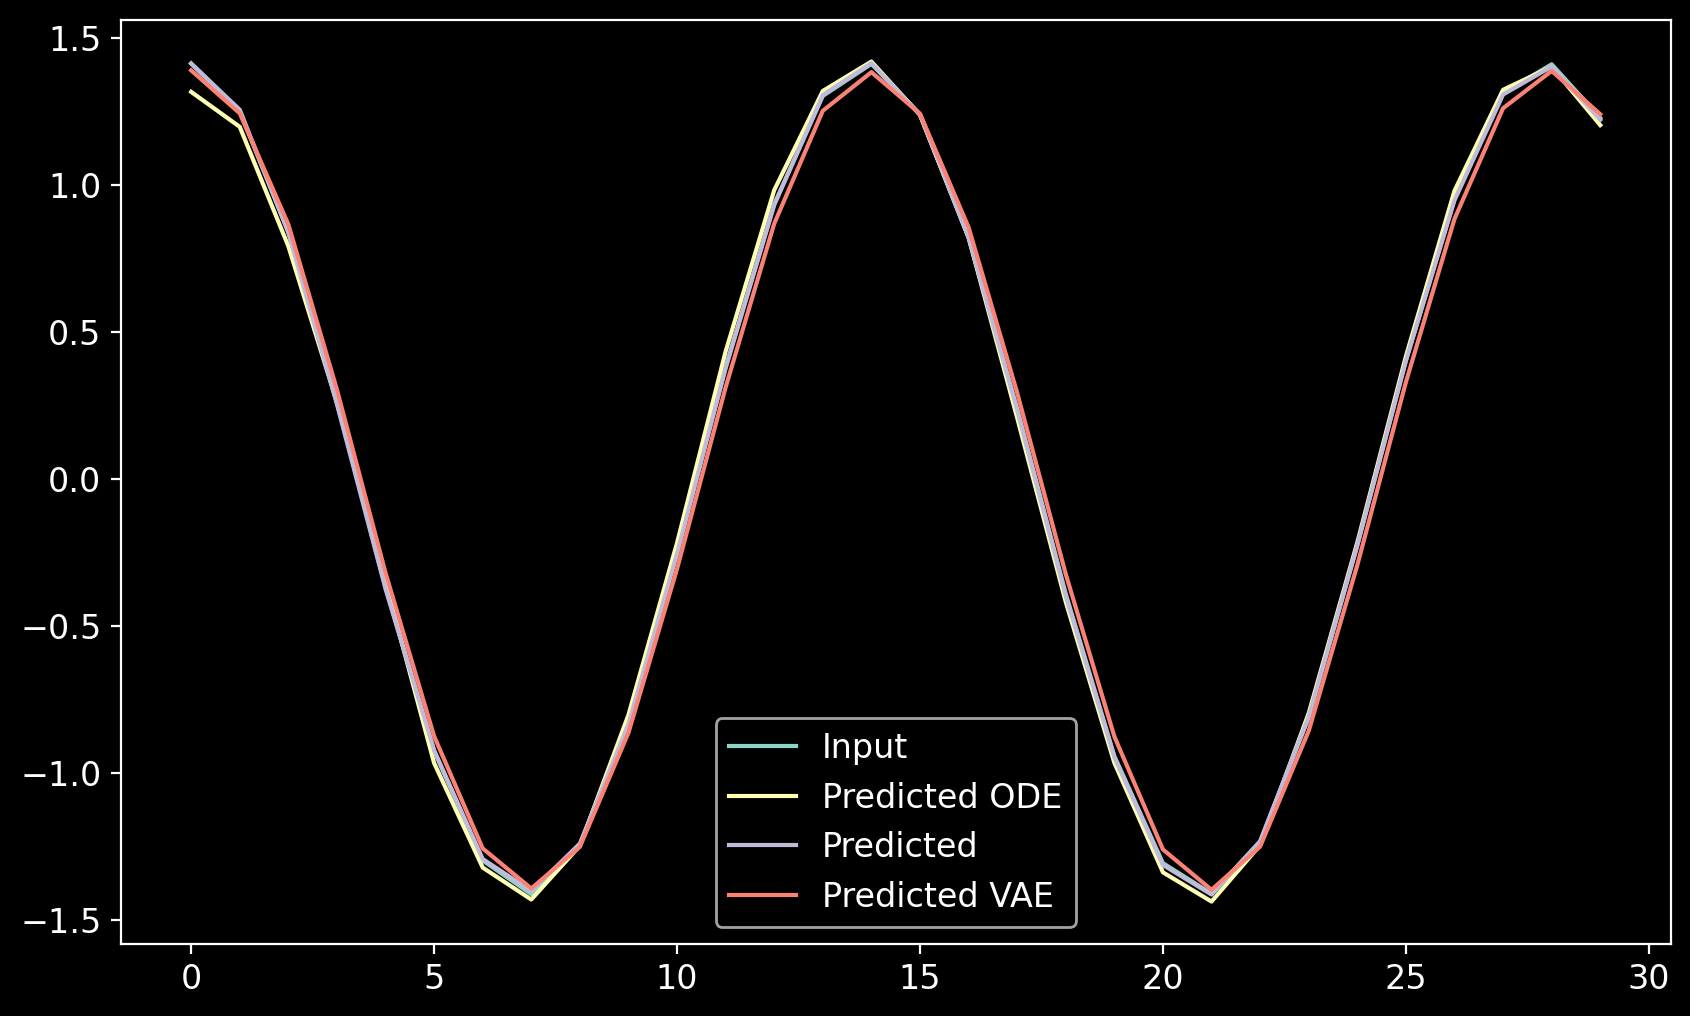

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(_input.squeeze(-1).detach().cpu().numpy()[0], label="Input");
ax.plot(x_hat_ode.squeeze(-1).detach().cpu().numpy()[0], label="Predicted ODE");
ax.plot(x_hat.squeeze(-1).detach().cpu().numpy()[0], label="Predicted");
ax.plot(x_hat_vae.squeeze(-1).detach().cpu().numpy()[0], label="Predicted VAE");
ax.legend()

In [39]:
x_hat = model.predict(x_input, 30)
x_hat_vae = model_vae.predict(x_input, 30)
x_hat_ode = model_ode.predict(x_input, 30)

#loss = nn.functional.mse_loss(x_hat, _input)
#loss_vae = nn.functional.mse_loss(x_hat_vae, _input)

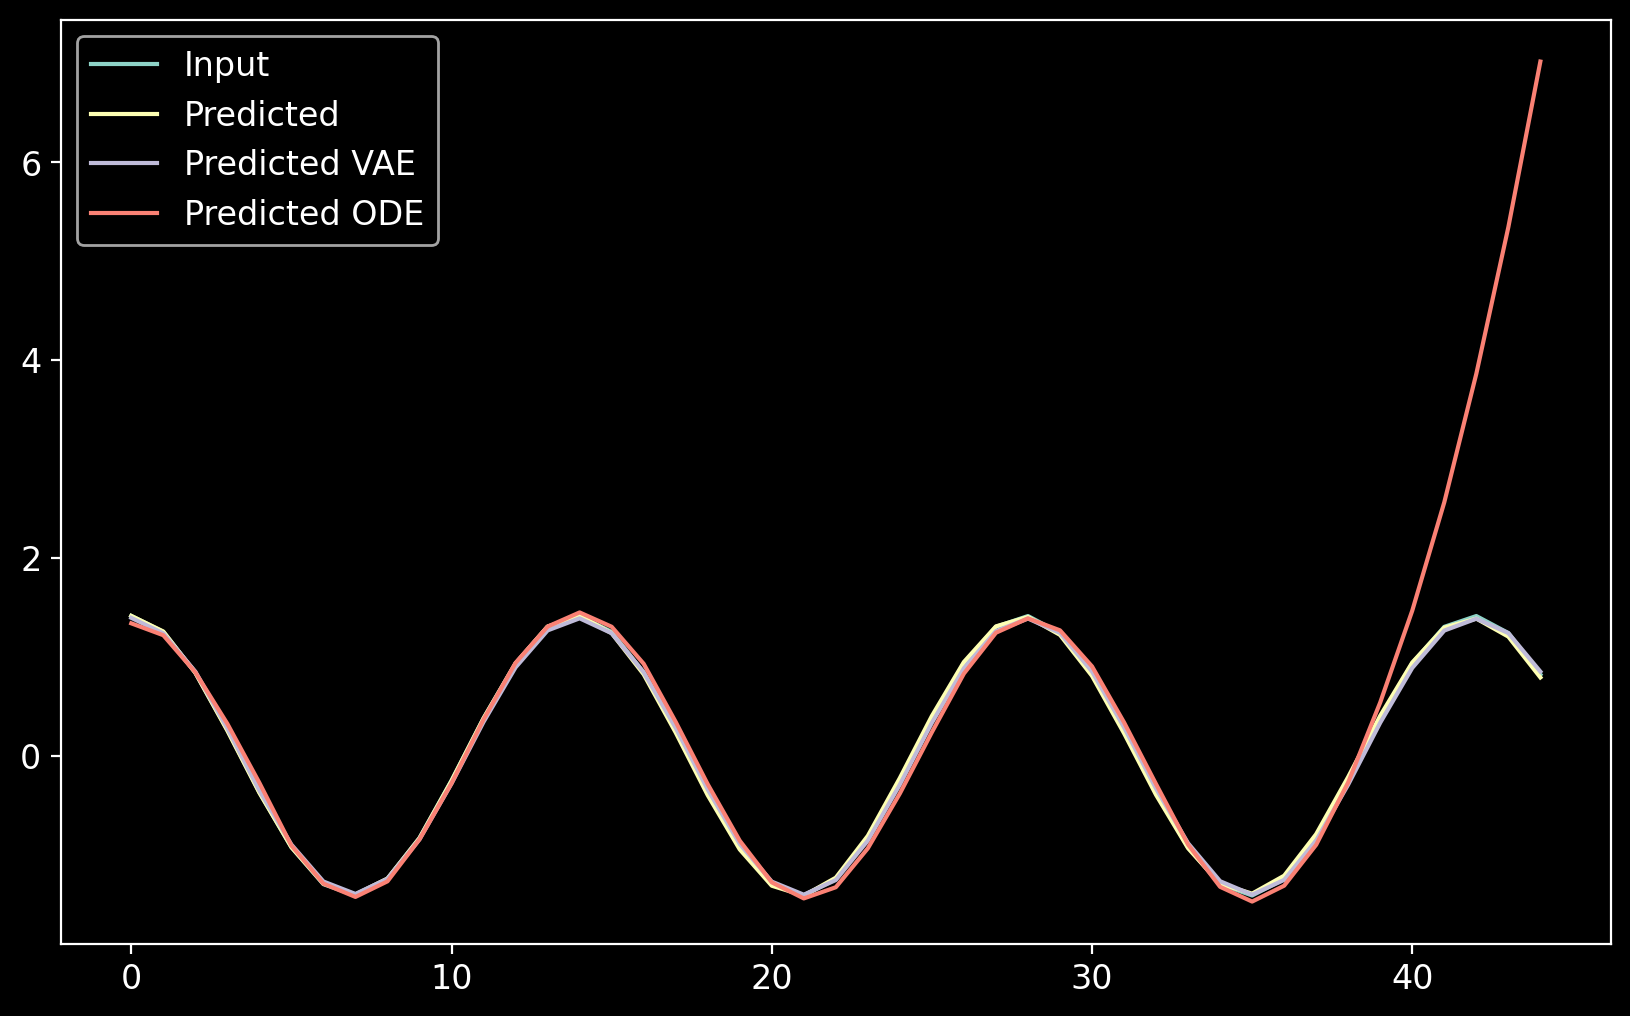

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_input.reshape(-1).detach().cpu()[0:45], label="Input");
ax.plot(x_hat.squeeze(-1).detach().cpu().numpy()[0], label="Predicted");
ax.plot(x_hat_vae.squeeze(-1).detach().cpu().numpy()[0], label="Predicted VAE");
ax.plot(x_hat_ode.squeeze(-1).detach().cpu().numpy()[0], label="Predicted ODE");
ax.legend()